<a href="https://colab.research.google.com/github/amura/DetectingDeepFakes/blob/compute-visual-features/DetectingDeepFakesPart2_ComputeVisualFeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
from PIL.ImageStat import Stat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import cv2

# some settings to make it smoothly runnable in Jupyter
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline
import matplotlib.pyplot as plt

## Provided solution from the first part


In [3]:
# install required
!pip install opencv-python mtcnn db  jasper glib   2>&1

     |████████████████████████████████| 2.3MB 7.8MB/s 
     |████████████████████████████████| 174kB 51.3MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
  Created wheel for db: filename=db-0.1.1-cp37-none-any.whl size=3895 sha256=4aadf77f35367d692f9b88d5e91334000bde7e0a26790d3ddc4e1d2841e92a6e
  Stored in directory: /root/.cache/pip/wheels/30/eb/ba/237fa002d1d1b2e73cedcefd26a9db37c4b72c7e5156ea0501
  Created wheel for glib: filename=glib-1.0.0-cp37-none-any.whl size=2594 sha256=5c091f19a597140eb73557755c0ad754ef2abc46fac7d27461c1d17dca04e111
  Stored in directory: /root/.cache/pip/wheels/a8/21/79/bbc3cc29e5d14dfb72eee89df860316408976c33bc14659a97
  Created wheel for antiorm: filename=antiorm-1.2.1-cp37-none-any.whl size=31679 sha256=70c1976fbc0f6801c39d5e0c5046f69335f95d7cce42f673ac1544027f8b7dff
  Stored in directory: /root/.cache/pip/wheels/b0/91/4d/f8fe808786ff1cda9e7e99e1b1bbda9196ab26786017965313
Successfully built

In [4]:

def eyes_angle(left_eye, right_eye):
    # find the distances between X and Y coordinates of both eyes
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    # compute the angle using trigonometry
    angle = np.degrees(np.arctan2(dY, dX))
    return angle
    
def scaling_factor(left_eye, right_eye, desired_left_eye, desired_right_eye):
    # find the distances between X and Y coordinates of both eyes
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    # find the actual distance between eyes (the hypotenuse)
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    # find the distance between X and Y coordinates in the desired face (which we will have after scaling)
    desired_dY = desired_right_eye[1] - desired_left_eye[1]
    desired_dX = desired_right_eye[0] - desired_left_eye[0]
    # find the  distance between desired eye coordinates (the hypotenuse)
    desired_dist = np.sqrt((desired_dX ** 2) + (desired_dY ** 2))
    
    # compute the ratio between distances, which is the scale factor
    scaling_factor = desired_dist / dist
    return scaling_factor
    

def crop_and_align(image, left_eye, right_eye, desired_image_width, 
                   desired_left_eye_percentage):
    # find angle of the line between the eyes
    angle = eyes_angle(left_eye, right_eye)

    # assuming desired_left_eye_percentage tells where the eyes should be relative to the image size
    # compute its actual place in the resulted image
    desired_left_eye = (desired_left_eye_percentage[0]*desired_image_width, 
                        desired_left_eye_percentage[1]*desired_image_width)
    # similar compute the mirror coordinates for desired_right_eye
    desired_right_eye = ((1.0-desired_left_eye_percentage[0])*desired_image_width, 
                        desired_left_eye_percentage[1]*desired_image_width)

    # find scaling factor based on where we want our eyes to be in the resulted image
    scale = scaling_factor(left_eye, right_eye, desired_left_eye, desired_right_eye)
    
    # find the center point between two eyes, around which we will rotate the image
    eyes_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    # compute the rotation matrix using OpenCV, rotate and scale around the eyes_center
    M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

    # move the current center of the eyes to the desired coordinates, which are
    # mid point horizontally and the desired level vertically
    tX = desired_image_width * 0.5
    tY = desired_left_eye[1]
    M[0, 2] += (tX - eyes_center[0])
    M[1, 2] += (tY - eyes_center[1])

    # by specifying height and width of the final image
    # as our desired_image_width, we insruct warpAffine to cut off the extra pixels
    w = desired_image_width
    h = desired_image_width

    # using OpenCV warpAffine() apply the M transformation, which will also crop the image
    aligned = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    return aligned

from mtcnn import MTCNN
detector = MTCNN()

# detect one face and its eyes coordinates in the given image
def detect_face(image, desired_size=224, desired_left_eye_percentage=(0.35, 0.35)):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detection_result = detector.detect_faces(image_rgb)
    left_eye = detection_result[0]['keypoints']['left_eye']
    right_eye = detection_result[0]['keypoints']['right_eye']
    face = crop_and_align(image, left_eye, right_eye, desired_size, desired_left_eye_percentage)
    if face is not None:
        return face
    return None

# loop through frames in the video and detect faces
def detect_and_save_faces(video_path, limit_faces=-1, save_faces=True):
    detector = MTCNN()
    faces = list()
    # add '_face' at the end to differentiate face images
    face_name = os.path.splitext(video_path)[0] + '_face'
    
    cap = cv2.VideoCapture(video_path)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for frame_no in range(num_frames):
        # if the given limit is not -1, loop only until the limit
        if limit_faces != -1 and frame_no >= limit_faces:
            break
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret, frame = cap.read()
        # detect faces
        face = detect_face(frame, desired_size=256, desired_left_eye_percentage=(0.35, 0.35))
        if face is not None:
            faces.append(face)
            if save_faces:
                cv2.imwrite(face_name + '_' + str(frame_no) + '.png', face)
    return faces

## Data download and extraction


In [5]:
# paths to target folders
DEEPFAKES='/content/deepfakes/fakes'
REAL='/content/deepfakes/real'

try:
      os.makedirs(DEEPFAKES)
except OSError:
      pass

try:
      os.makedirs(REAL)
except OSError:
      pass



In [6]:
#download dataset
tf.keras.utils.get_file("deepfake.tar.gz","https://lp-prod-resources.s3.amazonaws.com/other/detectingdeepfakes/DeepfakeTIMIT.tar.gz", extract=False)
!tar -xf /root/.keras/datasets/deepfake.tar.gz -C /content/deepfakes/fakes/

226615296/226611200 [==============================] - 5s 0us/step


In [7]:
tf.keras.utils.get_file("VidTIMIT.zip", "https://lp-prod-resources.s3.amazonaws.com/other/detectingdeepfakes/VidTIMIT.zip", extract=True)
!mv /root/.keras/datasets/VidTIMIT/* /content/deepfakes/real/

1358815232/1358810924 [==============================] - 33s 0us/step


In [8]:
%cd /content/deepfakes

/content/deepfakes


In [9]:
# running provided code on real and fake video
real_faces = detect_and_save_faces('./real/fram1/sa2.avi', limit_faces=5)
fake_faces = detect_and_save_faces('./fakes/DeepfakeTIMIT/higher_quality/fram1/sa2-video-fadg0.avi', limit_faces=5)

In [ ]:
# Analysis of fake vs real images
from google.colab.patches import cv2_imshow


plt.figure(figsize=(20, 50))
imgIndex = 1
i = 0
nrows = len(real_faces) 

for img1,img2 in zip(enumerate(real_faces), enumerate(fake_faces)): 
  print('Rows and counts', nrows, imgIndex)
  #load real vs fake image
  ax1 = plt.subplot(nrows, 2, imgIndex)
  ax1.imshow(cv2.cvtColor(img1[1], cv2.COLOR_BGR2RGB))
  ax = plt.subplot(nrows, 2, imgIndex + 1)  
  ax.imshow(cv2.cvtColor(img2[1], cv2.COLOR_BGR2RGB))
  imgIndex += 2



### Exploring brightness and contrast

Brightness and contrast adjustments
Increasing (/ decreasing) the β value will add (/ subtract) a constant value to every pixel. Pixel values outside of the [0 ; 255] range will be saturated (i.e. a pixel value higher (/ lesser) than 255 (/ 0) will be clamped to 255 (/ 0)).

A dark image will have many pixels with low color value and a histogram will present a peak in its left part. When adding a constant bias, the histogram is shifted to the right as we have added a constant bias to all the pixels.
The α parameter will modify how the levels spread. If α<1, the color levels will be compressed and the result will be an image with less contrast.

In [ ]:

alpha = 1.0 # Simple contrast control
beta = 50   # Simple brightness control

cv2_imshow(cv2.convertScaleAbs(fake_faces[0], alpha=0.5, beta=beta))
cv2_imshow(cv2.convertScaleAbs(fake_faces[0], alpha=alpha, beta=0))
cv2_imshow(cv2.convertScaleAbs(fake_faces[0], alpha=1.5, beta=20))
cv2_imshow(cv2.convertScaleAbs(fake_faces[0], alpha=3, beta=beta))
cv2_imshow(cv2.convertScaleAbs(fake_faces[0], alpha=3, beta=100))


### Image histograms


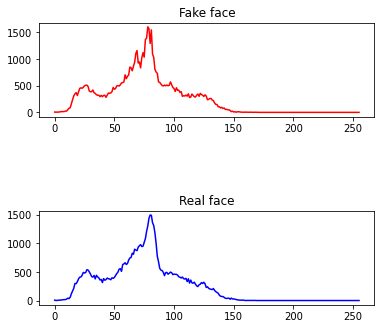

In [12]:
fig = plt.figure()
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1, wspace=0.9)

ax = fig.add_subplot(2,1,1)

hFake = cv2.calcHist([fake_faces[0]],[0],None,[256],[0,256])  
ax.plot(hFake,color = 'red')
ax.set_title('Fake face')

ax2 = fig.add_subplot(2,1,2)
hReal = cv2.calcHist([real_faces[0]],[0],None,[256],[0,256])
ax2.set_title('Real face')
ax2.plot(hReal,color = 'blue')

### Comparing histrograms

Following options available

* cv2.HISTCMP_CORREL: Computes the correlation between the two histograms.
* cv2.HISTCMP_CHISQR: Applies the Chi-Squared distance to the histograms.
* cv2.HISTCMP_INTERSECT: Calculates the intersection between two histograms.
* cv2.HISTCMP_BHATTACHARYYA: Bhattacharyya distance, used to measure the “overlap” between the two histograms.

**Larger Correlation and Intersection implies high similarity. 
Others, a SMALLER value indicates higher similarity (Chi-Squared and Hellinger)** 

In [13]:
# compare two histrograms
def computeHistDiffs(real_image, fake_image):    
    hFake = cv2.calcHist([fake_image],[0],None,[256],[0,256])  
    hReal = cv2.calcHist([real_image],[0],None,[256],[0,256])  
    hist_correl = cv2.compareHist(hFake, hReal, cv2.HISTCMP_CORREL)    
    hist_intersect = cv2.compareHist(hFake, hReal, cv2.HISTCMP_INTERSECT)   
    hist_hellinger = cv2.compareHist(hFake, hReal, cv2.HISTCMP_HELLINGER)   
    hist_chisqr = cv2.compareHist(hFake, hReal, cv2.HISTCMP_CHISQR)  
    return [hist_correl, hist_intersect, hist_hellinger, hist_chisqr]

print('Compare real with real')
print(computeHistDiffs(real_faces[0], real_faces[0]))
print('Compare real with fake')
print(computeHistDiffs(real_faces[0], fake_faces[0]))

Compare real with real
[1.0, 65536.0, 0.0, 0.0]
Compare real with fake
[0.981032353042123, 61581.0, 0.05676709802153556, 1789.662719511666]


In [14]:
from skimage.measure import compare_ssim

gray_orig = cv2.cvtColor(real_faces[0], cv2.COLOR_BGR2GRAY)
gray_mod = cv2.cvtColor(fake_faces[0], cv2.COLOR_BGR2GRAY)

print('SSI of same real image')

(score, diff) = compare_ssim(gray_orig, gray_orig, full=True)
diff = (diff * 255).astype("uint8")
print("Structural Similarity Index (Same image): {}".format(score))

(score, diff) = compare_ssim(gray_orig, gray_mod, full=True)
diff = (diff * 255).astype("uint8")
print("Structural Similarity Index (Fake vs Real): {}".format(score))

SSI of same real image
Structural Similarity Index (Same image): 1.0
Structural Similarity Index (Fake vs Real): 0.7590054420530187


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  if sys.path[0] == '':


In [15]:

import imutils
thresh = cv2.threshold(diff, 0, 25, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [20]:
# method for computing image features for differences
def compute_features(source):
    blurred =cv2.GaussianBlur(source, (7,7),0)
    res = np.hstack((source,blurred))     
    (score, diff) = compare_ssim(source, blurred , full=True, multichannel=True)
    mse = skimage.metrics.normalized_root_mse(source, blurred) 
    hist = computeHistDiffs(source, blurred)       
    features = np.concatenate([[score],[mse], hist])
    return features

In [21]:
import skimage.metrics
# loop through frames of fake video, then perform blur of image
for i in fake_faces:
  features = compute_features(i)
  print(features)
  

[9.75119049e-01 2.63698878e-02 9.96433087e-01 6.34310000e+04
 4.73654961e-02 8.59761989e+02]
[9.78339104e-01 2.41177510e-02 9.96215032e-01 6.34450000e+04
 4.64203711e-02 1.01395497e+03]
[9.77704872e-01 2.40430203e-02 9.96071608e-01 6.32800000e+04
 4.63005218e-02 8.71469676e+02]
[9.78963551e-01 2.32706513e-02 9.94800738e-01 6.32400000e+04
 4.59662134e-02 1.10070296e+03]
[9.77053656e-01 2.40131696e-02 9.93267283e-01 6.30440000e+04
 4.96462197e-02 1.32455563e+03]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


### Save in hd5 format

In [22]:
import h5py

def save_hdf5(path, feature):
   with h5py.File(path, 'w') as hf: 
        Xset = hf.create_dataset(name='features', data=feature)


save_hdf5('realvideo.h5', compute_features(real_faces[0]))    
save_hdf5('fakevideo.h5', compute_features(fake_faces[0]))    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
